I have made use of numpy for mathematical operations such as exponential, summation, dot product, matrix inverse, matrix multiplication, matplotlib for plotting and math module for Inf constant and exponentiation




No tool set is used for finding the centers and spread of the RBF function of the neurons. 

a.The centers correponding to each hidden layer neuron is found using KMeans concepts implemented here in the code below

b.The spread/radius of each gaussian is found using K Nearest Neighbour function implemented here in the code below

c.Code for the Neural network including forward pass, backpropagation and gradient descent is coded below


 

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
def softmax(vec):
    """
        The function transform vec to corresponding probabilities [0,1] and such that sum of result = 1
    """    
    value = np.exp(vec)
    return value / np.sum(value, axis = 1, keepdims = True)

def prediction_loss(predicted_class, actual_class):
    """
        The function return how much the prediction differs from the true labels/actual class
        predicted_class has the probabilities of each class
    """
    #find the the probability corresponding to the actual class
    predicted_prob_actual_class = predicted_class[np.arange(len(predicted_class)), actual_class]
    #Summation of the log of probabilites will give the entropy of the entire training sample
    entropy = -1.0 * np.sum(np.log(predicted_prob_actual_class)) / len(actual_class)
    return entropy

def accuracy(predicted_class, actual_class):
    """
        The function returns what percentage of predicted_class is same as the actual class
    """
    predicted_class = np.argmax(predicted_class, axis=1) #find the label with maximum probability 
    total_correct_predictions = np.sum([a==b for a,b in zip(predicted_class,actual_class)]) #check how many predicted class labels is same as actual class
    accuracy = 100 * total_correct_predictions / len(actual_class)
    return accuracy    

def oneHotEncoding(data,classes):
    """
        The target labels are converted to one hot vector, where one value will be 1 corresponding to the label
        and the rest will be 0
    """    
    one_hot_vector = np.zeros((len(data),classes))
    for i,c in enumerate(data):
        one_hot_vector[i][c]=1
    return one_hot_vector    

In [3]:
def euclidian_distance(a,b):
    """
        Function returns the straight line distance between two points
        Euclidian Distance in Rn = Sqrt((a1-b1)^2 + (a2-b2)^2 + ... + (an-bn)^2 )
    """
    return math.sqrt(np.sum((a-b)**2))

def KMeans(features,k,max_iter=350):
    """
        Input: Set of points/feature vectors
               k number of clusters that can be formed from the feature vectors
        Output: k Centers/ points from the feature vector that is representative of the clusters
        Procedure: Randomly initialize the centers from the feature vector, for each point in the feature vector 
                   assign it to the closest center using euclidan distance, 
                   After all points are assigned to a center/cluster, find the mean of points with each cluster
                   to get the new centers
                   Repeat this procedure until max iterations or until the centers do not change
    """
    centers = features[:k].copy() #pick k initial centers
    for l in range(max_iter):
        center_maps = {i :[] for i in range(0,k) } #center_maps holds the points assigned to each cluster i
        for point in features:
            min_distance = math.inf
            #find the closet center out of the k centers
            for i in range(len(centers)):
                ED = euclidian_distance(point,centers[i])
                if(ED < min_distance):
                    min_distance =  ED
                    ck = i            
            #add the point to the cluster ck
            center_maps[ck].append(point)
        #recenter the clusters by finding the mean of the points in each cluster
        j=0    
        for cluster in center_maps:
            centers[j] = np.average(center_maps[cluster],axis=0)
            j=j+1
    return centers

def KNN(features,centers,kneighbours):
    """
        Returns kneighbours that are closest to each centers, this is useful in finding the spread/radius of the gaussian
        Input: Features in Rn
               centers that are representative of the cluster
               kneighbour number of neighbours
        Procedure: For each center find the distances to every other point in the feature space, pick the k nearest neighbours
    """
    #to store the k nearest neighbour for center i
    neighbours = {i:[] for i in range(len(centers))}
    for i, cj in enumerate(centers):
        #for each center find k nearest neighbours
        distances = []
        for point in features:
            if(np.sum(point == cj) == len(point)): #do not include the point itself as its own neighbour, make the distance as infinite
                distances.append(math.inf)
            else:
                #find the euclidian distance between center cj and the point 
                distances.append(euclidian_distance(point,cj))  
        #argpartition is used to return the k smallest in the distance list      
        indices = np.argpartition(distances, kneighbours)[:kneighbours]
        neighbours[i].append(features[indices])

    #this is to convert the dictionary to a numpy array
    temp = []
    for i in neighbours:
        temp.append(neighbours[i][0])
    return np.array(temp)

In [4]:
def find_radius(centers,neighbours):
    """
        Input: centers and its nearest neigbours
        Output: Radius/spread
        Procedure: Radius =  Sqrt((Sum(center-ith_neighbour)^2)/k)
    """
    radii = []
    k = len(neighbours[0])
    #for each center find the root mean square of the distances to the neighbour
    for i,cj in enumerate(centers):
        dist = 0
        for ck in neighbours[i]:
            dist += np.sum((cj-ck)**2)
        #root mean square of the distances to the neighbours give the spread
        radii.append(math.sqrt(dist/k))
    return radii

def RadialBasisFunction(X,centers,radius):
    """
        Input: Training feature vectors
               Centers corresponding of the gaussian of each hidden neuron
               Radius corresponding of the gaussian of each hidden neuron 
        Output: for each cj of hidden layer: exp (-0.5*||x-cj||^2)

    """
    hidden_layer = np.zeros((X.shape[0],len(centers)))
    rows = len(X)
    cols = len(centers)

    #its a fully connected layer between Xi and RBF layer totally row*col computations
    for i in range(rows): 
        for j in range(cols):
            hidden_layer[i][j] = np.exp(-0.5* euclidian_distance(X[i],centers[j]) / radius[j]**2)
    return hidden_layer

In [5]:
def forward_pass(rbf_layer,W,b):
    """
        The output layer is the linear function of rbf neuron and the weights between RBF layer and output layer
        Following the linear operation is softmax, to predict the output probabilities of each class
    """
    output_layer = np.dot(rbf_layer, W) + b
    predicted = softmax(output_layer)
    return rbf_layer,predicted

def gradient_descent(trainx,rbf_layer,one_hot_vector,actual_classes,W,b,epochs=5000,eta=0.01,rlambda=0.01):
    """
    In every epoch, there is a forward pass through the training data
    find the gradient of the loss function with respect to weights, bias, hidden layers using back propagation
    Update the parameters using the gradients from last step
    """
    loss_list = []
    for epch in range(epochs):
        rbf_layer, predicted = forward_pass(rbf_layer,W,b)
        
        ### begin back propagation
        gradient_L_wrt_y = (predicted - one_hot_vector) / predicted.shape[0]  #this is the gradient of cross entropy loss 
        gradient_L_wrt_W = np.dot(rbf_layer.T, gradient_L_wrt_y)  #gradient of loss with respect to the final weights
        gradient_L_wrt_b = np.sum(gradient_L_wrt_y, axis = 0, keepdims = True) #gradient of loss with respect to the final layer bias
        
        ### end back propagation
        
        #L2 Norm controlled by hyperparameter rlambda 
        gradient_L_wrt_W += rlambda * W #this is an exponential sum acts as the momentum
        
        #update the paramaters using the gradients of loss 
        W = W - eta * gradient_L_wrt_W
        b = b - eta * gradient_L_wrt_b

        if(epch % 500)== 0:
            loss = prediction_loss(predicted, actual_classes)
            print('Loss at step {0}: {1}'.format(epch, loss))
            loss_list.append(loss)
    return W,b,predicted,loss_list    

        
Find weights,centers and stds for each gaussian/rbf function


centers is found using kmeans

radius is calculated using k nearest neighbour



# ***Checking if the RBF works for 2 input XOR function***

In [6]:
classes = 2
trainx = np.array([[0,0],[0,1],[1,0],[1,1]])
trainy = np.array([0,1,1,0])
one_hot_vector = oneHotEncoding(trainy,classes=2)    

kcenters= 4
kneighbours = 2
centers = KMeans(trainx,kcenters)
kNearestNeighbours = KNN(trainx,centers,kneighbours)
radius = find_radius(centers,kNearestNeighbours)
rbf_layer = RadialBasisFunction(trainx,centers,radius)

W = np.random.normal(0, 1, [kcenters, classes]) 
b = np.zeros((1, classes))

weights,biases,predictions,loss_list = gradient_descent(trainx,rbf_layer,one_hot_vector,trainy,W,b,epochs=5000,eta=0.01,rlambda=0.01)
predicted_classes = np.argmax(predictions, axis = 1)
print("Prediction",predicted_classes)
print("Number of misclassification = {}".format(len(trainy) - sum(predicted_classes == trainy)))


#finding weights using squared error loss
A = np.dot(rbf_layer.T, rbf_layer)
psuedoInverse = np.dot(np.linalg.inv(A),rbf_layer.T)
optimal_weights = np.dot(psuedoInverse,trainy)
print("Optimal weights using squared error loss",optimal_weights)

Loss at step 0: 0.7179943485343807
Loss at step 500: 0.6356016172504038
Loss at step 1000: 0.5899951571033608
Loss at step 1500: 0.5527912123029705
Loss at step 2000: 0.5220865630448306
Loss at step 2500: 0.49642369047144813
Loss at step 3000: 0.47471112778568486
Loss at step 3500: 0.4561367813653332
Loss at step 4000: 0.4400939654987139
Loss at step 4500: 0.4261245577776597
Prediction [0 1 1 0]
Number of misclassification = 0
Optimal weights using squared error loss [-1.60090157  1.97043297  1.97043297 -1.60090157]


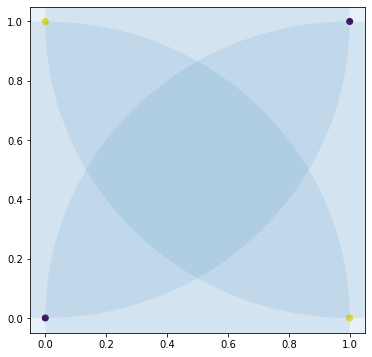

In [7]:
fig,axes = plt.subplots(1,figsize=(6,6))
axes.scatter(trainx[:,0],trainx[:,1],c=trainy)
for j in range(kcenters):
    c = plt.Circle((centers[j][0],centers[j][1]),radius[j],alpha=0.1)
    axes.add_artist(c)
plt.show()

# ***Checking if the RBF works for 3 input XOR function***

In [8]:
classes = 2
trainx = np.array([[0,0,0],[0,0,1],[0,1,0],[0,1,1],[1,0,0],[1,0,1],[1,1,0],[1,1,1]])
trainy = np.array([0,1,1,0,1,0,0,1])
one_hot_vector = oneHotEncoding(trainy,classes=2)    

kcenters= 8
kneighbours = 2
centers = KMeans(trainx,kcenters)
kNearestNeighbours = KNN(trainx,centers,kneighbours)
radius = find_radius(centers,kNearestNeighbours)
rbf_layer = RadialBasisFunction(trainx,centers,radius)

W = np.random.normal(0, 1, [kcenters, classes]) 
b = np.zeros((1, classes))

weights,biases,predictions,loss_list = gradient_descent(trainx,rbf_layer,one_hot_vector,trainy,W,b,epochs=5000,eta=0.01,rlambda=0.01)
predicted_classes = np.argmax(predictions, axis = 1)
print("Prediction",predicted_classes)
print("Number of misclassification = {}".format(len(trainy) - sum(predicted_classes == trainy)))

#finding weights using squared error loss
A = np.dot(rbf_layer.T, rbf_layer)
psuedoInverse = np.dot(np.linalg.inv(A),rbf_layer.T)
optimal_weights = np.dot(psuedoInverse,trainy)
print("Optimal weights using squared error loss\n",list(optimal_weights))

Loss at step 0: 0.8141778855221581
Loss at step 500: 0.6832025897131808
Loss at step 1000: 0.6619194458496623
Loss at step 1500: 0.6437314338485182
Loss at step 2000: 0.627981428911391
Loss at step 2500: 0.6141775829198883
Loss at step 3000: 0.6019521704942205
Loss at step 3500: 0.5910288053587777
Loss at step 4000: 0.5811975892798453
Loss at step 4500: 0.5722968426868639
Prediction [0 1 1 0 1 0 0 1]
Number of misclassification = 0
Optimal weights using squared error loss
 [-1.986156861458419, 2.1980473918544607, 2.198047391854441, -1.986156861458413, 2.198047391854451, -1.9861568614584162, -1.9861568614584026, 2.1980473918544536]


In [9]:
def getData():
    from sklearn.datasets import load_iris
    datax = load_iris()['data']
    datay = load_iris()['target']
    
    training_index = [ y for x in [range(5,45),range(55,95),range(105,145)] for y in x]
    testing_index = [y for x in [range(0,5),range(45,55),range(95,105),range(145,150)] for y in x]
    
    trainx =  datax[training_index]
    trainy =  datay[training_index]
    
    testx = datax[testing_index]
    testy = datay[testing_index]
    
    print(len(trainx),len(trainy))
    print(len(testx),len(testy))
        
    return trainx,trainy,testx,testy

The image below is the architecture for the RBF Neural Net used for the classification of IRIS dataset

(The image was created using google draw (also available in the report for this Assignment)

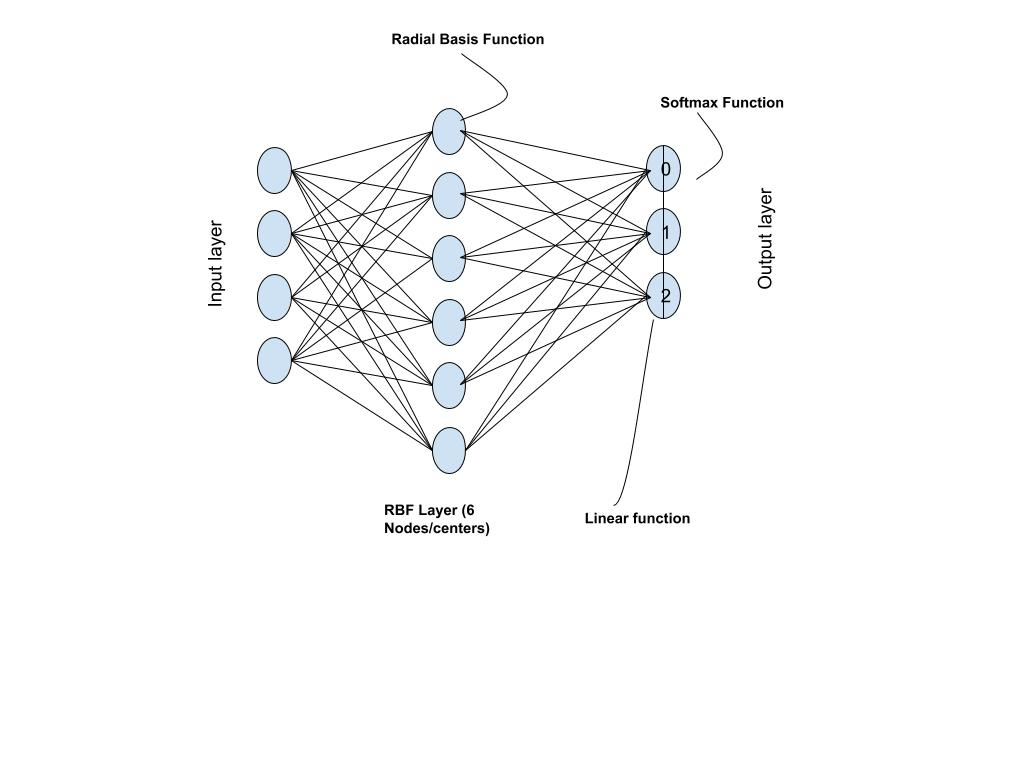

In [10]:
classes = 3
trainx,trainy,testx,testy = getData()
one_hot_vector = oneHotEncoding(trainy,classes)

#6,10--90% 80
#6 12 90 86.8
kcenters= 6  
kneighbours = 15
centers = KMeans(trainx,kcenters)
kNearestNeighbours = KNN(trainx,centers,kneighbours)
radius = find_radius(centers,kNearestNeighbours)
rbf_layer = RadialBasisFunction(trainx,centers,radius)

W = np.random.normal(0, 1, [kcenters, classes]) 
b = np.zeros((1, classes))


weights,biases,predictions,loss_list = gradient_descent(trainx,rbf_layer,one_hot_vector,trainy,W,b,epochs=5000,eta=0.01,rlambda=0.01)
predicted_classes = np.argmax(predictions, axis = 1)
print("Number of misclassification = {}".format(len(trainy) - sum(predicted_classes == trainy)))
print('Training accuracy: {0:.2f}%'.format(100*sum(predicted_classes == trainy)/len(trainy)))

120 120
30 30
Loss at step 0: 1.363112556960716
Loss at step 500: 1.2456909497813247
Loss at step 1000: 1.150052154213281
Loss at step 1500: 1.0694052255866888
Loss at step 2000: 1.0012612582940676
Loss at step 2500: 0.9435614288639236
Loss at step 3000: 0.8945610154100447
Loss at step 3500: 0.8528013127213779
Loss at step 4000: 0.8170737385077516
Loss at step 4500: 0.7863823611147417
Number of misclassification = 13
Training accuracy: 89.17%


In [11]:
rbf_layer_test = RadialBasisFunction(testx,centers,radius)
_,test_predictions = forward_pass(rbf_layer_test,weights,biases)
test_predicted_class = np.argmax(test_predictions, axis=1)
print('Test accuracy: {0:.2f}%'.format(100*sum(test_predicted_class == testy)/len(testy)))

Test accuracy: 86.67%


In [12]:
print(test_predicted_class)
print(testy)

[0 0 0 0 0 0 0 0 0 0 2 1 2 1 1 1 1 1 1 1 2 1 2 2 2 2 2 2 2 1]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]


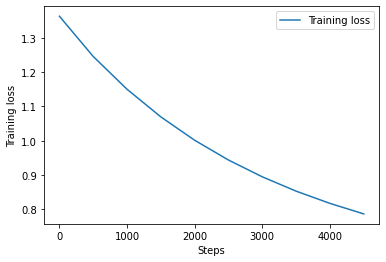

In [13]:
plt.plot(range(1,5001,500),loss_list,label="Training loss")
plt.legend()
plt.xlabel("Steps")
plt.ylabel("Training loss")
plt.show()

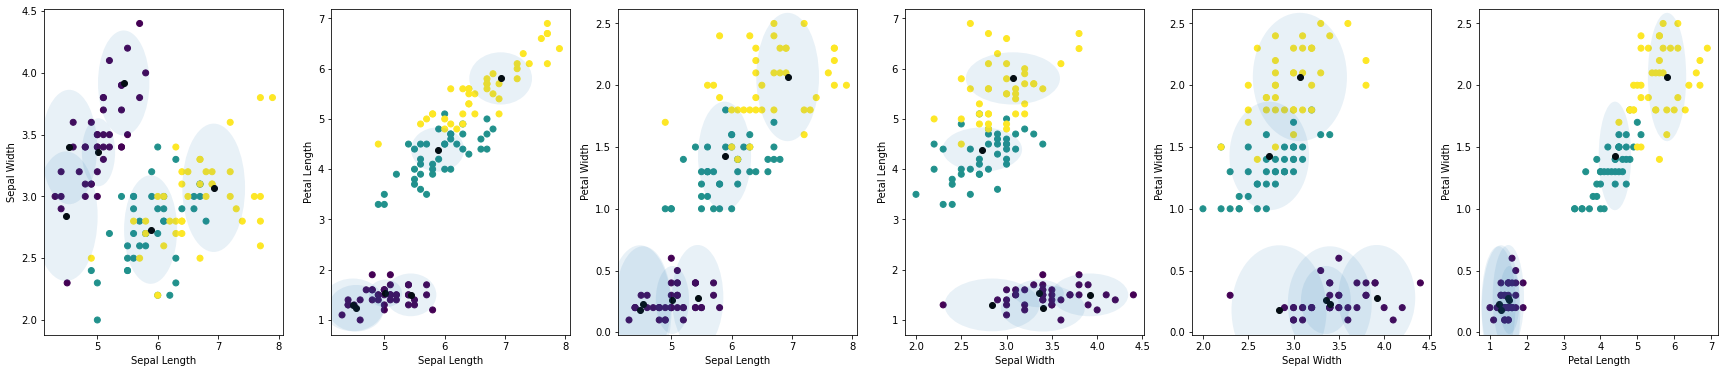

In [14]:
features = ["Sepal Length","Sepal Width","Petal Length","Petal Width"]
cord = [[0,1],[0,2],[0,3],[1,2],[1,3],[2,3]]
fig,axes = plt.subplots(1,6,figsize=(30,6))

for i in range(6):   
    axes[i].scatter(trainx[:,cord[i][0]],trainx[:,cord[i][1]],c=trainy)
    for j in range(kcenters):
        axes[i].scatter(centers[j][cord[i][0]],centers[j][cord[i][1]],c="black")
        c = plt.Circle((centers[j][cord[i][0]],centers[j][cord[i][1]]),radius[j],alpha=0.1)
        axes[i].add_artist(c)
        axes[i].set_xlabel(features[cord[i][0]])
        axes[i].set_ylabel(features[cord[i][1]])
plt.show()